In [1]:
import torch

import os
os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def _get_cuda_autotune_config():
    configs = []
    for num_stages, num_warps in [
        (2, 4),
        (2, 8),
        (3, 4),
        (3, 8),
        (4, 4),
        (4, 8),
    ]:
        for BLOCK_SIZE_M in [16, 32, 64, 128]:#, 128]:
            for BLOCK_SIZE_N in [32, 64, 128]:#[64, 128]:
                for BLOCK_SIZE_K in [16, 32]:#[16, 32]:
                    configs.append(
                        triton.Config(
                            {
                                "GROUP_SIZE_M" : 1,
                                "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                            }, 
                            num_stages=num_stages, 
                            num_warps=num_warps
                        ),
                    )                        
    # return configs

    return [triton.Config(
                                {
                                    "GROUP_SIZE_M" : 1,
                                    "BLOCK_SIZE_M" : 16,
                                    "BLOCK_SIZE_N" : 16,
                                    "BLOCK_SIZE_K" : 16,
                                },
                                num_stages=4, 
                                num_warps=4
                            )]

In [28]:
@triton.jit
def to_int4(v):
    return v - 0x8


@triton.jit
def to_mxint4(v):
    sign = (v & 0x8) != 0
    mag  = (v & 0x7)
    return tl.where(sign, -mag, mag)


@triton.jit
def to_mxfp4(x):
    s = (x & 0x8) != 0
    e = (x & 0x6) >> 1
    m  = (x & 0x1)
    v = tl.where(e!=0, (1 << (e - 1)) * (1 + 0.5 * m), 0.5 * m)
    return tl.where(s, -v, v)


@triton.autotune(
    configs=_get_cuda_autotune_config(),
    key=[],
)
@triton.jit
def matmul_trellis_kernel(
        a_ptr, b_ptr, c_ptr,  #
        M, K, N,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        BLOCK_SIZE_M: tl.constexpr, 
        BLOCK_SIZE_K: tl.constexpr,  #
        BLOCK_SIZE_N: tl.constexpr, 
        GROUP_SIZE_M: tl.constexpr,  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    pid = tl.program_id(axis=0)
    grid_n = tl.cdiv(N, BLOCK_SIZE_N)
    pid_m = pid // grid_n
    pid_n = pid % grid_n

    # pid = tl.program_id(axis=0)
    # num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    # num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    
    # num_pid_in_group = GROUP_SIZE_M * num_pid_n
    # group_id = pid // num_pid_in_group
    # first_pid_m = group_id * GROUP_SIZE_M
    # group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    # pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    # pid_n = (pid % num_pid_in_group) // group_size_m


    tl.assume(N % BLOCK_SIZE_N == 0)
    tl.assume(K % BLOCK_SIZE_K == 0)

    tl.assume(N >= BLOCK_SIZE_N)
    tl.assume(K >= BLOCK_SIZE_K)


    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % N
    offs_ak = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_ak[None, :] * stride_ak)


    offs_bk = tl.arange(0, BLOCK_SIZE_K // 16)

    pos_bn_low = tl.arange(0, (BLOCK_SIZE_N * 4))
    offs_bn_low = (pid_n * (BLOCK_SIZE_N * 4) + pos_bn_low) % (N * 4)

    pos_bn_high = tl.arange(1, 1 + (BLOCK_SIZE_N * 4))
    pos_bn_high = tl.where(pos_bn_high % 64 == 0, pos_bn_high - 64, pos_bn_high)
    offs_bn_high = (pid_n * (BLOCK_SIZE_N * 4) + pos_bn_high) % (N * 4)
        
    b_ptrs_low = b_ptr + (offs_bk[:, None] * stride_bk + offs_bn_low[None, :] * stride_bn)
    b_ptrs_high = b_ptr + (offs_bk[:, None] * stride_bk + offs_bn_high[None, :] * stride_bn)
    
    shifter = tl.arange(0, 4) * 4

    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_ak[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        bits_low = tl.load(b_ptrs_low) #, mask=offs_bk[:, None] < K // 16 - k * BLOCK_SIZE_K // 16, other=0.0)#.reshape(BLOCK_SIZE_K // 16, 64, BLOCK_SIZE_N // 16))        
        print("bits_low", bits_low)
        
        bits_high = tl.load(b_ptrs_high) #, mask=offs_bk[:, None] < K // 16 - k * BLOCK_SIZE_K // 16, other=0.0)#.reshape(BLOCK_SIZE_K // 16, 64, BLOCK_SIZE_N // 16)
        print("bits_high", bits_high)

        print("b_ptrs_low", b_ptrs_low)
        print("b_ptr", b_ptr)
        # c = tl.cast(bits_low, tl.int16, bitcast=True)
        # print("c", c)
        c = tl.atomic_add(b_ptr, b_ptr)
        print()

        codes = bits_low.to(tl.uint16) | (bits_high.to(tl.uint16) << 8)
        print("codes (groud truth)", codes)

        codes = ((codes.to(tl.uint32) * 34038481) >> 9).to(tl.uint16)

        bits = (codes[:, :, None] >> shifter[None, None, :]) & 0xF
        
        # w = to_int4(bits)
        w = to_mxint4(bits)
        # w = to_mxfp4(bits)
        # w = mxfp4_lut(bits)

        w = tl.reshape(w, BLOCK_SIZE_K, BLOCK_SIZE_N).to(tl.float16)

        accumulator = tl.dot(a, w, accumulator, out_dtype=accumulator_dtype)
        
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs_high += (BLOCK_SIZE_K // 16) * stride_bk
        b_ptrs_low += (BLOCK_SIZE_K // 16) * stride_bk


    c = accumulator.to(tl.float16)
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def trellis_matmul_triton(a, b_compressed):
    assert a.shape[1] == b_compressed.shape[0] * 16, "Incompatible dimensions"

    M, K = a.shape
    N = b_compressed.shape[-1] // 4

    # Init out ptr
    c = torch.empty((M, N), device=b_compressed.device, dtype=torch.float16)

    grid = lambda META: (triton.cdiv(M, META["BLOCK_SIZE_M"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]), )

    matmul_trellis_kernel[grid](
        a, b_compressed, c,
        M, K, N,
        a.stride(0), 
        a.stride(1),
        b_compressed.stride(0), 
        b_compressed.stride(1),
        c.stride(0), 
        c.stride(1),
    )
    return c


In [29]:
torch.manual_seed(0)
M, K, N = 3 * (16,)
WEIGHT_BLOCKS = [K // 16, N // 16]
x_compressed = torch.randint(-128, 128, (WEIGHT_BLOCKS[0], WEIGHT_BLOCKS[1] * 64), dtype=torch.int8, device="cuda")
# #x_decompressed = decode_trellis_python(x_compressed)
y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)**0.5

x_compressed.shape


o = trellis_matmul_triton(y, x_compressed)

bits_low [[  85   97   -9   60 -119 -116   39   93  -46  -71  -98  -43 -114  108
    62  -32 -116  -77   74  -81   88  113   67   19 -122  -79  -88 -126
   -65  -29 -106  -41  -30  -13  -36  -42  -88  -47   62  -18  -58   18
    99  -76   12  -21   89  -35    8   53   77   55  123 -107   42  102
    41  123  109  -97   55   93  117 -115]]
bits_high [[  97   -9   60 -119 -116   39   93  -46  -71  -98  -43 -114  108   62
   -32 -116  -77   74  -81   88  113   67   19 -122  -79  -88 -126  -65
   -29 -106  -41  -30  -13  -36  -42  -88  -47   62  -18  -58   18   99
   -76   12  -21   89  -35    8   53   77   55  123 -107   42  102   41
   123  109  -97   55   93  117 -115   85]]
b_ptrs_low [[719344064 719344065 719344066 719344067 719344068 719344069 719344070
  719344071 719344072 719344073 719344074 719344075 719344076 719344077
  719344078 719344079 719344080 719344081 719344082 719344083 719344084
  719344085 719344086 719344087 719344088 719344089 719344090 719344091
  719344092 719344

InterpreterError: ValueError('atomic_add does not support int8')

In [15]:
97 << 8 | 85

24917

In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
def decode_uint16_to_int4_python(bits):
    bits = bits.to(torch.int32)
    val0 = (bits >> 12) & 0xF
    val1 = (bits >> 8) & 0xF
    val2 = (bits >> 4) & 0xF
    val3 = bits & 0xF

    sign0 = (val0 & 0x8) != 0
    sign1 = (val1 & 0x8) != 0
    sign2 = (val2 & 0x8) != 0
    sign3 = (val3 & 0x8) != 0
    
    dtype = torch.int8

    mag0 = (val0 & 0x7).to(dtype)
    mag1 = (val1 & 0x7).to(dtype)
    mag2 = (val2 & 0x7).to(dtype)
    mag3 = (val3 & 0x7).to(dtype)
    
    w0 = torch.where(sign0, -mag0, mag0)
    w1 = torch.where(sign1, -mag1, mag1)
    w2 = torch.where(sign2, -mag2, mag2)
    w3 = torch.where(sign3, -mag3, mag3)

    return torch.stack([w0, w1, w2, w3], dim=-1)


#torch.compile
def permute_16bits(x):
    x = x.to(torch.int32) * 34038481
    x = (x >> 9) # & 0xFFFF
    return x.to(torch.uint16)


#@torch.compile()
def decode_trellis_python(bits):
    M, N = bits.shape[0], bits.shape[1]
    
    even_codes = bits.view(torch.uint16)
    odd_codes = bits.roll(shifts=-1, dims=-1).view(torch.uint16)

    codes = torch.stack([even_codes, odd_codes], dim=-1).reshape(M, N, 64)
    
    bits = permute_16bits(codes)
    decoded = decode_uint16_to_int4_python(bits)

    return (
        decoded
        .reshape(M, N, 16, 16)      # Разворачиваем в 4D: (N, M, 16, 16)
        .permute(0, 2, 1, 3)        # Меняем оси → (N, 16, M, 16)
        .reshape(M * 16, N * 16)    # Сшиваем в один большой 2D тензор
    )


def torch_to_mxfp4(x):
    s = (x & 0x8) != 0
    e = (x & 0x6) >> 1
    m  = (x & 0x1)
    v = torch.where(e!=0, (1 << (e - 1)) * (1 + 0.5 * m), 0.5 * m)
    return torch.where(s, -v, v)


def test_2x2():
    BLOCKS = [2, 2]
    x_compressed = torch.randint(0, 255, (BLOCKS[0], BLOCKS[1], 64), dtype=torch.uint8, device="cuda")
    x_decompressed = decode_trellis_python(x_compressed)
    x_compressed_00 = x_compressed[0, 0][None, None, :]
    x_decompressed_00 = decode_trellis_python(x_compressed_00)
    assert torch.all(x_decompressed_00 == x_decompressed[:16, :16])

    x_compressed_01 = x_compressed[0, 1][None, None, :]
    x_decompressed_01 = decode_trellis_python(x_compressed_01)
    assert torch.all(x_decompressed_01 == x_decompressed[:16, 16:32])

    x_compressed_10 = x_compressed[1, 0][None, None, :]
    x_decompressed_10 = decode_trellis_python(x_compressed_10)
    assert torch.all(x_decompressed_10 == x_decompressed[16:32, :16])

    x_compressed_11 = x_compressed[1, 1][None, None, :]
    x_decompressed_11 = decode_trellis_python(x_compressed_11)
    assert torch.all(x_decompressed_11 == x_decompressed[16:32, 16:32])
    print("Test 2x2 passed!")

# test_2x2()

#@torch.compile
def trellis_matmul_torch(y, x_compressed):
    x_decompressed = decode_trellis_python(x_compressed)
    return y @ x_decompressed.to(torch.float16)
    

torch.manual_seed(0)
M, K, N = 3 * (16,)
WEIGHT_BLOCKS = [K // 16, N // 16]
x_compressed = torch.randint(-128, 128, (WEIGHT_BLOCKS[0], WEIGHT_BLOCKS[1] * 4), dtype=torch.int8, device="cuda")
# #x_decompressed = decode_trellis_python(x_compressed)
y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)**0.5

x_compressed.shape


o = trellis_matmul_triton(y, x_compressed)

# o1 = trellis_matmul_torch(y, x_compressed)

# # # from trellis_M_16_16 import trellis_matmul_triton
# o2 = trellis_matmul_triton(y, x_compressed)
# print(matmul_trellis_kernel.best_config)

# # assert torch.all(torch.isclose(o1, o2))


matmul-performance:
        K    M       N  torch_fp16  triton_trellis
0  1024.0  1.0  1024.0    0.146286        0.136533
1  2048.0  1.0  2048.0    0.184869        0.227556
2  4096.0  1.0  4096.0    0.248096        0.339895
3  8192.0  1.0  8192.0    0.306960        0.436907


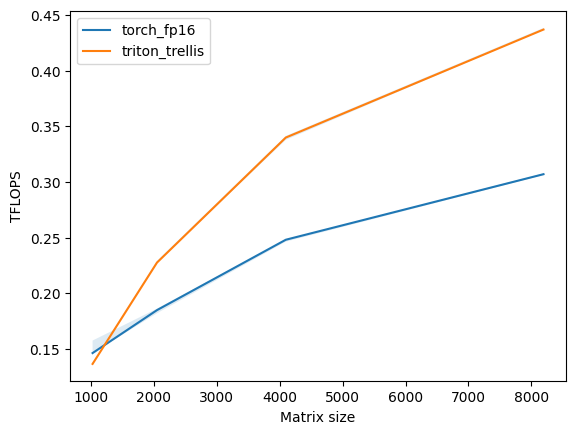

In [ ]:
BS = 1
sizes = [1024, 2048, 4096, 8192]
configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],  
        # x_vals=[(size, BS * size, size) for size in sizes],
        x_vals=[(size, BS, size) for size in sizes],
        line_arg="provider",  
        line_vals=[
            "torch_fp16", 
            "triton_trellis"
        ],
        line_names=[
            "torch_fp16", 
            "triton_trellis"
        ],  
        ylabel="TFLOPS",
        xlabel="Matrix size",
        plot_name="matmul-performance",
        args={},
    ))

@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    # a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    # b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    y = torch.randn(M, K, dtype=torch.float16, device="cuda")

    # x_compressed = torch.randint(0, 255, (K // 16, N // 16, 64), dtype=torch.uint8, device="cuda")
    x_compressed = torch.randint(0, 255, (K // 16, N * 4), dtype=torch.uint8, device="cuda")
    # x_compressed = torch.randint(0, 255, (N * 4, K // 16), dtype=torch.uint8, device="cuda").T

    # x_decompressed = decode_trellis_python(x_compressed).to(torch.float16)
    x_decompressed = torch.randn(K, N, dtype=torch.float16, device="cuda")

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y, x_decompressed), quantiles=quantiles)
    if provider == "torch_trellis":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: trellis_matmul_torch(y, x_compressed), quantiles=quantiles)
    if provider == 'triton_trellis':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: trellis_matmul_triton(y, x_compressed), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=False, print_data=True)

In [ ]:
print(matmul_trellis_kernel.best_config)

GROUP_SIZE_M: 1, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 32, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
